In [1]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from torchvision.transforms import functional as TF
from sklearn.model_selection import StratifiedKFold


In [2]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Step 2: Define paths (edit these if needed)
zip_path = "/content/drive/MyDrive/dataset_V3.zip"  # <-- change this if your file is in a folder
extract_dir = "/content/dataset_V3"

# Step 3: Unzip the dataset
import zipfile

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Extracted dataset to: {extract_dir}")

In [ ]:
# Step 4 (Optional): Copy the CSV if it's also on Drive
# If your CSV is in MyDrive, adjust the path accordingly

csv_drive_path = "/content/drive/MyDrive/dataset_V3.csv"
csv_colab_path = "/content/dataset_V3.csv"

!cp "{csv_drive_path}" "{csv_colab_path}"

print(f"✅ CSV copied to: {csv_colab_path}")


In [ ]:
from torchvision.transforms import functional as TF

class PadToSquareWithMean:
    def __call__(self, image):
        w, h = image.size
        max_dim = max(w, h)
        pad_left = (max_dim - w) // 2
        pad_top = (max_dim - h) // 2
        pad_right = max_dim - w - pad_left
        pad_bottom = max_dim - h - pad_top

        # Compute mean color of the image (as RGB tuple)
        mean_color = image.resize((1, 1)).getpixel((0, 0))

        # Apply padding using the mean color
        return TF.pad(image, (pad_left, pad_top, pad_right, pad_bottom),
                      fill=mean_color, padding_mode='constant')


In [ ]:
# ========== Config ==========
CSV_PATH = "dataset_V3.csv"
IMAGE_DIR = "/content/dataset_V3/dataset_V3"
BATCH_SIZE = 64

# ========== Dataset ==========
class CataractDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = {"low": 0, "moderate": 1, "high": 2, "mature": 3, "poor dilation": 4}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row["filename"] + ".jpg")
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Missing image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.data))

        label = self.label_map[row["label"].lower()]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# ========== Load and Prepare CSV ==========
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.rename(columns={"Frame Name": "filename"}, inplace=True)

# Derive label column from binary indicators
df["label"] = None
df.loc[df["Low Nuclear Density"] == 1.0, "label"] = "low"
df.loc[df["Moderate Nuclear Density"] == 1.0, "label"] = "moderate"
df.loc[df["High Nuclear Density"] == 1.0, "label"] = "high"
df.loc[df["Mature"] == 1.0, "label"] = "mature"
df.loc[df["Poor Dilation"] == 1.0, "label"] = "poor dilation"


# Keep only valid rows
df = df[df["label"].notna()]
df = df[["filename", "label"]]

# ========== Train / Val / Test Split ==========
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df["label"], random_state=42)

# Map labels to integer indices
label_map = {"low": 0, "moderate": 1, "high": 2, "mature": 3, "poor dilation": 4}
train_df["class_idx"] = train_df["label"].map(label_map)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df["class_idx"]),
    y=train_df["class_idx"]
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# ========== Transforms ==========
transform = transforms.Compose([
    PadToSquareWithMean(),  # <-- add this at the top
    transforms.Resize((260, 260)),  # match model input size
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3)
])
val_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# # ========== Datasets and Dataloaders ==========
# train_dataset = CataractDataset(train_df, IMAGE_DIR, transform)
# # val_dataset = CataractDataset(val_df, IMAGE_DIR, transform)
# # test_dataset = CataractDataset(test_df, IMAGE_DIR, transform)
# val_dataset = CataractDataset(val_df, IMAGE_DIR, val_test_transform)
# test_dataset = CataractDataset(test_df, IMAGE_DIR, val_test_transform)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # ========== Return Utility ==========
# def get_dataloaders():
#     return train_loader, val_loader, test_loader, class_weights_tensor, df


In [ ]:
import torch.nn as nn
from torchvision import models

def efficientnet_b2(weights="DEFAULT", fine_tune=True):
    """
    EfficientNet-B2 adapted to 5 classes.

    Parameters
    ----------
    weights : str | torchvision.models.EfficientNet_B2_Weights | None
        "DEFAULT"  → ImageNet-1K weights (torchvision ≥0.15).
        None       → random initialization.
        Or pass an explicit EfficientNet_B2_Weights enum.
    fine_tune : bool
        True  → freeze everything except last two MBConv blocks + classifier.
        False → leave all layers trainable.

    Returns
    -------
    model : nn.Module
    """

    # 1) Load backbone
    eff_weights = (
        models.EfficientNet_B2_Weights.DEFAULT if weights == "DEFAULT" else weights
    )
    model = models.efficientnet_b2(weights=eff_weights)

    # 2) Freeze / unfreeze
    if fine_tune:
        for p in model.parameters():
            p.requires_grad = False
        # Unfreeze the deepest layers (features.6 & features.7) and the classifier
        for name, p in model.named_parameters():
            if name.startswith(("features.6", "features.7", "classifier")):
                p.requires_grad = True

    # 3) Replace classifier head (EffNet-B2 head = Sequential[Dropout, Linear])
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, 5)   # 5 classes

    return model


Using device: cuda

===== Fold 1 =====
Train samples in fold 1: 688
Validation samples in fold 1: 173
Total used in this fold: 861
Total remaining consistent with train_val_df: 861
Train dataset length after transforms: 688
Val dataset length after transforms: 173


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 200MB/s]


Model is on device: cuda:0
Epoch: [1/50] | Step: [1/11] | Loss: 1.652157
Epoch: [1/50] | Step: [6/11] | Loss: 1.402190
Epoch: [1/50] | Step: [11/11] | Loss: 0.844345
Epoch: [1/50] | Loss: 1.160910
Valid Loss: 0.490203 | Acc: 0.8439
Epoch: [2/50] | Step: [1/11] | Loss: 0.546255
Epoch: [2/50] | Step: [6/11] | Loss: 0.493231
Epoch: [2/50] | Step: [11/11] | Loss: 0.345611
Epoch: [2/50] | Loss: 0.452648
Valid Loss: 0.401694 | Acc: 0.8613
Epoch: [3/50] | Step: [1/11] | Loss: 0.310098
Epoch: [3/50] | Step: [6/11] | Loss: 0.239432
Epoch: [3/50] | Step: [11/11] | Loss: 0.142994
Epoch: [3/50] | Loss: 0.272044
Valid Loss: 0.246127 | Acc: 0.9249
Epoch: [4/50] | Step: [1/11] | Loss: 0.108329
Epoch: [4/50] | Step: [6/11] | Loss: 0.281315
Epoch: [4/50] | Step: [11/11] | Loss: 0.190774
Epoch: [4/50] | Loss: 0.254547
Valid Loss: 0.161940 | Acc: 0.9422
Epoch: [5/50] | Step: [1/11] | Loss: 0.346702
Epoch: [5/50] | Step: [6/11] | Loss: 0.222187
Epoch: [5/50] | Step: [11/11] | Loss: 0.190599
Epoch: [5/50] 

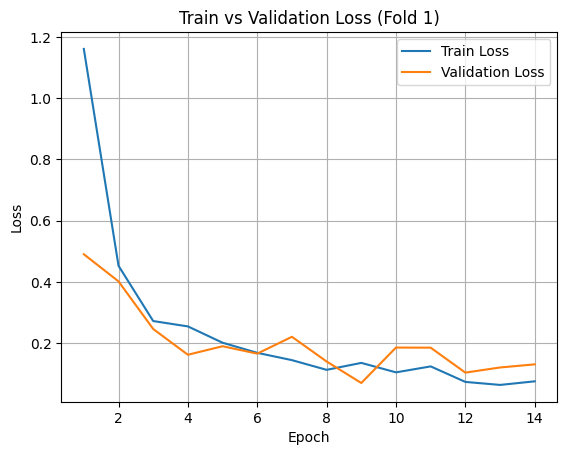

               precision    recall  f1-score   support

          low     1.0000    1.0000    1.0000        37
     moderate     1.0000    0.9655    0.9825        29
         high     0.9412    0.9412    0.9412        34
       mature     0.9574    1.0000    0.9783        45
poor dilation     1.0000    0.9643    0.9818        28

     accuracy                         0.9769       173
    macro avg     0.9797    0.9742    0.9767       173
 weighted avg     0.9774    0.9769    0.9769       173


===== Fold 2 =====
Train samples in fold 2: 689
Validation samples in fold 2: 172
Total used in this fold: 861
Total remaining consistent with train_val_df: 861
Train dataset length after transforms: 689
Val dataset length after transforms: 172
Model is on device: cuda:0
Epoch: [1/50] | Step: [1/11] | Loss: 1.667340
Epoch: [1/50] | Step: [6/11] | Loss: 1.118456
Epoch: [1/50] | Step: [11/11] | Loss: 0.772679
Epoch: [1/50] | Loss: 1.186154
Valid Loss: 0.656713 | Acc: 0.8023
Epoch: [2/50] | Step: [1

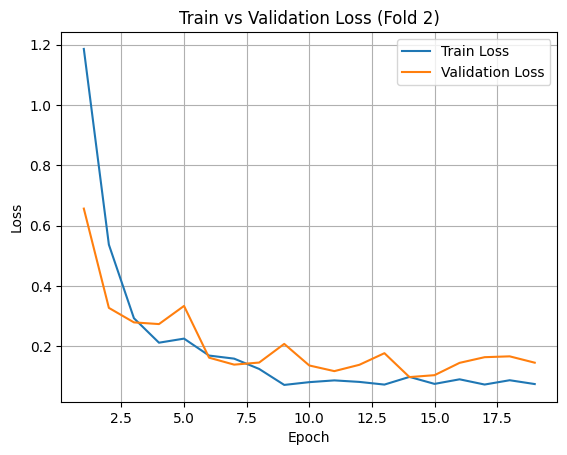

               precision    recall  f1-score   support

          low     0.9730    0.9730    0.9730        37
     moderate     0.9310    0.9643    0.9474        28
         high     0.9167    0.9706    0.9429        34
       mature     1.0000    0.9333    0.9655        45
poor dilation     1.0000    1.0000    1.0000        28

     accuracy                         0.9651       172
    macro avg     0.9641    0.9682    0.9657       172
 weighted avg     0.9665    0.9651    0.9653       172


===== Fold 3 =====
Train samples in fold 3: 689
Validation samples in fold 3: 172
Total used in this fold: 861
Total remaining consistent with train_val_df: 861
Train dataset length after transforms: 689
Val dataset length after transforms: 172
Model is on device: cuda:0
Epoch: [1/50] | Step: [1/11] | Loss: 1.629785
Epoch: [1/50] | Step: [6/11] | Loss: 1.086787
Epoch: [1/50] | Step: [11/11] | Loss: 0.772009
Epoch: [1/50] | Loss: 1.169806
Valid Loss: 0.723878 | Acc: 0.7326
Epoch: [2/50] | Step: [1

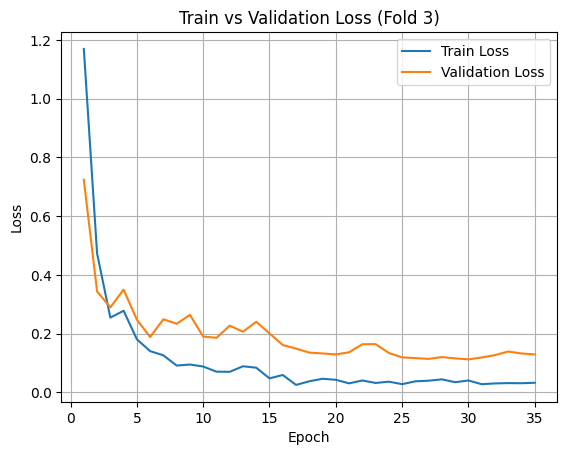

               precision    recall  f1-score   support

          low     1.0000    1.0000    1.0000        37
     moderate     1.0000    0.9286    0.9630        28
         high     0.9688    0.9394    0.9538        33
       mature     0.9565    0.9778    0.9670        45
poor dilation     0.9355    1.0000    0.9667        29

     accuracy                         0.9709       172
    macro avg     0.9722    0.9691    0.9701       172
 weighted avg     0.9718    0.9709    0.9709       172


===== Fold 4 =====
Train samples in fold 4: 689
Validation samples in fold 4: 172
Total used in this fold: 861
Total remaining consistent with train_val_df: 861
Train dataset length after transforms: 689
Val dataset length after transforms: 172
Model is on device: cuda:0
Epoch: [1/50] | Step: [1/11] | Loss: 1.620628
Epoch: [1/50] | Step: [6/11] | Loss: 1.182698
Epoch: [1/50] | Step: [11/11] | Loss: 0.592263
Epoch: [1/50] | Loss: 1.125889
Valid Loss: 0.476768 | Acc: 0.8140
Epoch: [2/50] | Step: [1

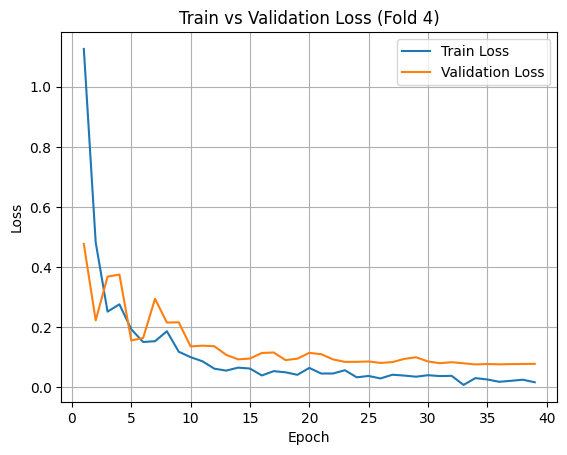

               precision    recall  f1-score   support

          low     0.9487    1.0000    0.9737        37
     moderate     0.9630    0.9286    0.9455        28
         high     0.9688    0.9394    0.9538        33
       mature     0.9778    0.9778    0.9778        45
poor dilation     1.0000    1.0000    1.0000        29

     accuracy                         0.9709       172
    macro avg     0.9716    0.9691    0.9702       172
 weighted avg     0.9711    0.9709    0.9708       172


===== Fold 5 =====
Train samples in fold 5: 689
Validation samples in fold 5: 172
Total used in this fold: 861
Total remaining consistent with train_val_df: 861
Train dataset length after transforms: 689
Val dataset length after transforms: 172
Model is on device: cuda:0
Epoch: [1/50] | Step: [1/11] | Loss: 1.655399
Epoch: [1/50] | Step: [6/11] | Loss: 1.107965
Epoch: [1/50] | Step: [11/11] | Loss: 0.819849
Epoch: [1/50] | Loss: 1.161093
Valid Loss: 0.552361 | Acc: 0.7907
Epoch: [2/50] | Step: [1

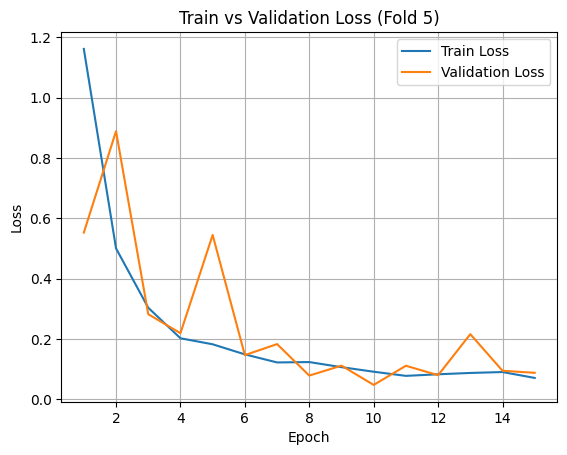

               precision    recall  f1-score   support

          low     1.0000    0.9730    0.9863        37
     moderate     0.9630    0.9286    0.9455        28
         high     0.8684    1.0000    0.9296        33
       mature     0.9778    0.9778    0.9778        45
poor dilation     1.0000    0.8966    0.9455        29

     accuracy                         0.9593       172
    macro avg     0.9618    0.9552    0.9569       172
 weighted avg     0.9629    0.9593    0.9597       172


===== Final Test Evaluation =====
               precision    recall  f1-score   support

          low     1.0000    0.9697    0.9846        33
     moderate     0.9583    0.9200    0.9388        25
         high     0.8485    0.9655    0.9032        29
       mature     0.9512    0.9750    0.9630        40
poor dilation     1.0000    0.8800    0.9362        25

     accuracy                         0.9474       152
    macro avg     0.9516    0.9420    0.9451       152
 weighted avg     0.9514 

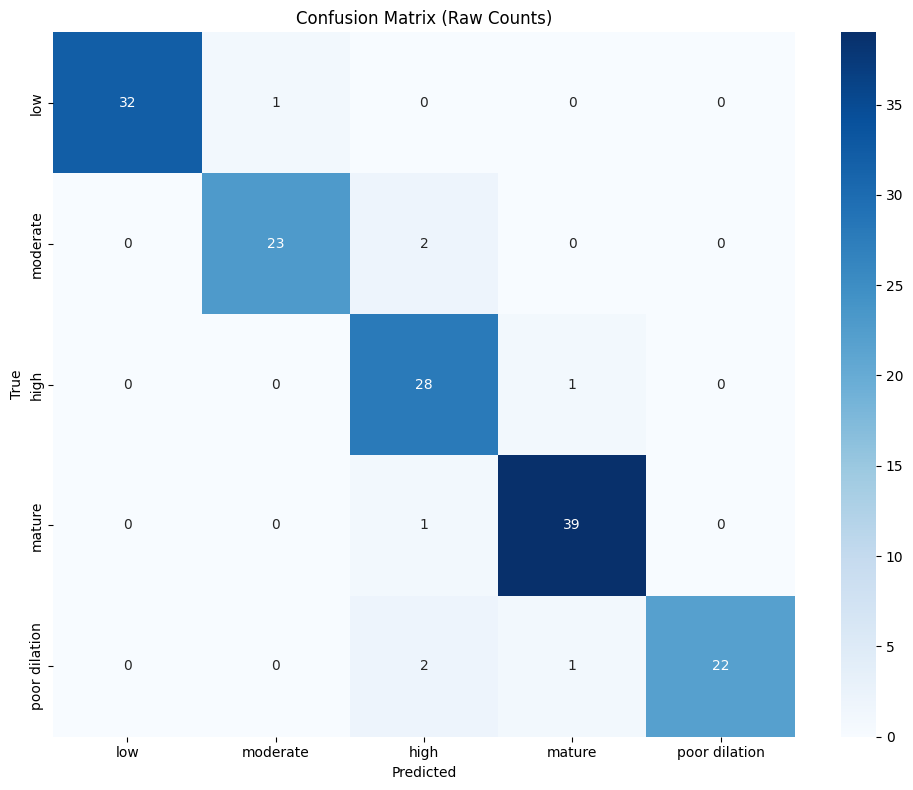

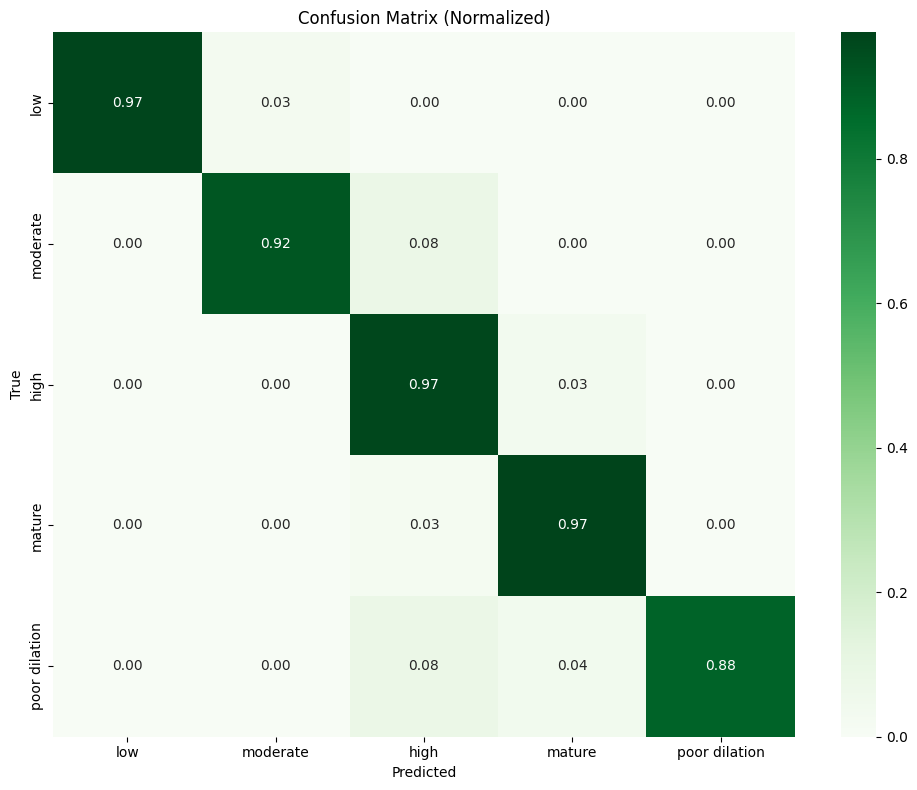

In [8]:
# ========== Train/Val/Test Split ==========
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


# Training settings
num_epochs = 50
patience = 5
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0
lr = 1e-3



DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# First: Split off 15% test set
train_val_df, test_df = train_test_split(
    df, test_size=0.15, stratify=df["label"], random_state=42
)

labels_train_val = train_val_df["label"].map(
    {"low":0, "moderate":1, "high":2, "mature":3, "poor dilation":4}
).values
labels_test = test_df["label"].map(
    {"low":0, "moderate":1, "high":2, "mature":3, "poor dilation":4}
).values

# Define classes
classes = ["low", "moderate", "high", "mature", "poor dilation"]

# Create test dataset and loader
test_dataset = CataractDataset(test_df, IMAGE_DIR, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# StratifiedKFold on remaining 85%
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)




fold_reports = []
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_df, labels_train_val)):
    print(f"\n===== Fold {fold+1} =====")

    # Reset early stopping for this fold
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Train/val splits
    train_df_fold = train_val_df.iloc[train_idx]
    val_df_fold = train_val_df.iloc[val_idx]

    print(f"Train samples in fold {fold+1}: {len(train_df_fold)}")
    print(f"Validation samples in fold {fold+1}: {len(val_df_fold)}")
    print(f"Total used in this fold: {len(train_df_fold) + len(val_df_fold)}")
    print(f"Total remaining consistent with train_val_df: {len(train_val_df)}")

    # Create datasets
    train_dataset = CataractDataset(train_df_fold, IMAGE_DIR, transform=transform)
    val_dataset   = CataractDataset(val_df_fold, IMAGE_DIR, transform=val_transform)

    # Report dataset lengths after transforms (should be identical)
    print(f"Train dataset length after transforms: {len(train_dataset)}")
    print(f"Val dataset length after transforms: {len(val_dataset)}")

    # # Create loaders
    # train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    # val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # print(f"Train samples in fold {fold+1}: {len(train_df_fold)}")
    # print(f"Validation samples in fold {fold+1}: {len(val_df_fold)}")
    # print(f"Total used in this fold: {len(train_df_fold) + len(val_df_fold)}")
    # print(f"Total remaining consistent with train_val_df: {len(train_val_df)}")


    # train_dataset = CataractDataset(train_val_df.iloc[train_idx], IMAGE_DIR, transform=transform)
    # val_dataset   = CataractDataset(train_val_df.iloc[val_idx], IMAGE_DIR, transform=val_transform)



    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # print(f"Train dataset length after transforms: {len(train_dataset)}")
    # print(f"Val dataset length after transforms: {len(val_dataset)}")


    # Compute class weights for this fold
    y_train_fold = [labels_train_val[i] for i in train_idx]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

#   Model
    model = efficientnet_b2(weights="DEFAULT", fine_tune=True)
    model = model.to(DEVICE)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)



    train_loss = []
    valid_loss = []

    print(f"Model is on device: {next(model.parameters()).device}")

    # Train loop
    num_steps = len(train_loader)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for j, (imgs, lbls) in enumerate(train_loader):
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            out = model(imgs)
            loss = loss_fn(out, lbls)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if j % 5 == 0:
                print(f'Epoch: [{epoch+1}/{num_epochs}] | Step: [{j+1}/{num_steps}] | Loss: {loss.item():.6f}')

        train_loss.append(running_loss / num_steps)
        print(f'Epoch: [{epoch+1}/{num_epochs}] | Loss: {train_loss[-1]:.6f}')

        # Validation
        model.eval()
        running_valid_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                out = model(imgs)
                loss_val = loss_fn(out, lbls)
                running_valid_loss += loss_val.item()
                predicted = torch.argmax(out, dim=1)
                correct += (predicted == lbls).sum().item()
                total += lbls.size(0)

        avg_val_loss = running_valid_loss / len(val_loader)
        valid_loss.append(avg_val_loss)
        acc_val = correct / total
        print(f'Valid Loss: {avg_val_loss:.6f} | Acc: {acc_val:.4f}')

        scheduler.step(avg_val_loss)

        # Early stopping
        if best_val_loss - avg_val_loss > min_delta:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    # Plot losses for this fold
    plt.figure()
    plt.plot(range(1, len(train_loss)+1), train_loss, label='Train Loss')
    plt.plot(range(1, len(valid_loss)+1), valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train vs Validation Loss (Fold {fold+1})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Validation report
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            out = model(imgs)
            preds = torch.argmax(out, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
    print(report)
    fold_reports.append(report)

# ===== Final Evaluation on Test Set =====
print("\n===== Final Test Evaluation =====")
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        out = model(imgs)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print(report)

# Confusion Matrices
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Raw Counts)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Normalized)')
plt.tight_layout()
plt.show()



In [9]:
# ========== Config ==========
CSV_PATH = "dataset_V3.csv"
IMAGE_DIR = "/content/dataset_V3/dataset_V3"
BATCH_SIZE = 64

# ========== Dataset ==========
class CataractDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = {"low": 0, "moderate": 1, "high": 2, "mature": 3, "poor dilation": 4}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row["filename"] + ".jpg")
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Missing image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.data))

        label = self.label_map[row["label"].lower()]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# ========== Load and Prepare CSV ==========
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.rename(columns={"Frame Name": "filename"}, inplace=True)

# Derive label column from binary indicators
df["label"] = None
df.loc[df["Low Nuclear Density"] == 1.0, "label"] = "low"
df.loc[df["Moderate Nuclear Density"] == 1.0, "label"] = "moderate"
df.loc[df["High Nuclear Density"] == 1.0, "label"] = "high"
df.loc[df["Mature"] == 1.0, "label"] = "mature"
df.loc[df["Poor Dilation"] == 1.0, "label"] = "poor dilation"


# Keep only valid rows
df = df[df["label"].notna()]
df = df[["filename", "label"]]

# ========== Train / Val / Test Split ==========
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df["label"], random_state=42)

# Map labels to integer indices
label_map = {"low": 0, "moderate": 1, "high": 2, "mature": 3, "poor dilation": 4}
train_df["class_idx"] = train_df["label"].map(label_map)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df["class_idx"]),
    y=train_df["class_idx"]
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# ========== Transforms ==========
transform = transforms.Compose([
    PadToSquareWithMean(),  # <-- add this at the top
    transforms.Resize((300, 300)),  # match model input size
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3)
])
val_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# # ========== Datasets and Dataloaders ==========
# train_dataset = CataractDataset(train_df, IMAGE_DIR, transform)
# # val_dataset = CataractDataset(val_df, IMAGE_DIR, transform)
# # test_dataset = CataractDataset(test_df, IMAGE_DIR, transform)
# val_dataset = CataractDataset(val_df, IMAGE_DIR, val_test_transform)
# test_dataset = CataractDataset(test_df, IMAGE_DIR, val_test_transform)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # ========== Return Utility ==========
# def get_dataloaders():
#     return train_loader, val_loader, test_loader, class_weights_tensor, df


In [10]:
import torch.nn as nn
from torchvision import models

def efficientnet_b3(weights="DEFAULT", fine_tune=True):
    """
    EfficientNet-B3 adapted to 5 classes.

    Parameters
    ----------
    weights : str | torchvision.models.EfficientNet_B3_Weights | None
        "DEFAULT"  → ImageNet-1K weights (torchvision ≥0.15).
        None       → random initialization.
        Or pass an explicit EfficientNet_B3_Weights enum.
    fine_tune : bool
        True  → freeze everything except last two MBConv blocks + classifier.
        False → leave all layers trainable.

    Returns
    -------
    model : nn.Module
    """

    # 1) Load backbone
    eff_weights = (
        models.EfficientNet_B3_Weights.DEFAULT if weights == "DEFAULT" else weights
    )
    model = models.efficientnet_b3(weights=eff_weights)

    # 2) Freeze / unfreeze
    if fine_tune:
        for p in model.parameters():
            p.requires_grad = False
        # Unfreeze the deepest layers (features.6 & features.7) and the classifier
        for name, p in model.named_parameters():
            if name.startswith(("features.6", "features.7", "classifier")):
                p.requires_grad = True

    # 3) Replace classifier head
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, 5)   # 5 classes

    return model


Using device: cuda

===== Fold 1 =====
Train samples in fold 1: 688
Validation samples in fold 1: 173
Total used in this fold: 861
Total remaining consistent with train_val_df: 861
Train dataset length after transforms: 688
Val dataset length after transforms: 173


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 217MB/s]


Model is on device: cuda:0
Epoch: [1/50] | Step: [1/11] | Loss: 1.624046
Epoch: [1/50] | Step: [6/11] | Loss: 1.215208
Epoch: [1/50] | Step: [11/11] | Loss: 0.848099
Epoch: [1/50] | Loss: 1.241843
Valid Loss: 0.718009 | Acc: 0.6936
Epoch: [2/50] | Step: [1/11] | Loss: 0.618623
Epoch: [2/50] | Step: [6/11] | Loss: 0.552721
Epoch: [2/50] | Step: [11/11] | Loss: 0.383572
Epoch: [2/50] | Loss: 0.524747
Valid Loss: 0.443671 | Acc: 0.8382
Epoch: [3/50] | Step: [1/11] | Loss: 0.301243
Epoch: [3/50] | Step: [6/11] | Loss: 0.341195
Epoch: [3/50] | Step: [11/11] | Loss: 0.252044
Epoch: [3/50] | Loss: 0.316443
Valid Loss: 0.395521 | Acc: 0.8555
Epoch: [4/50] | Step: [1/11] | Loss: 0.141872
Epoch: [4/50] | Step: [6/11] | Loss: 0.235923
Epoch: [4/50] | Step: [11/11] | Loss: 0.270796
Epoch: [4/50] | Loss: 0.259120
Valid Loss: 0.264592 | Acc: 0.8844
Epoch: [5/50] | Step: [1/11] | Loss: 0.176929
Epoch: [5/50] | Step: [6/11] | Loss: 0.194359
Epoch: [5/50] | Step: [11/11] | Loss: 0.396346
Epoch: [5/50] 

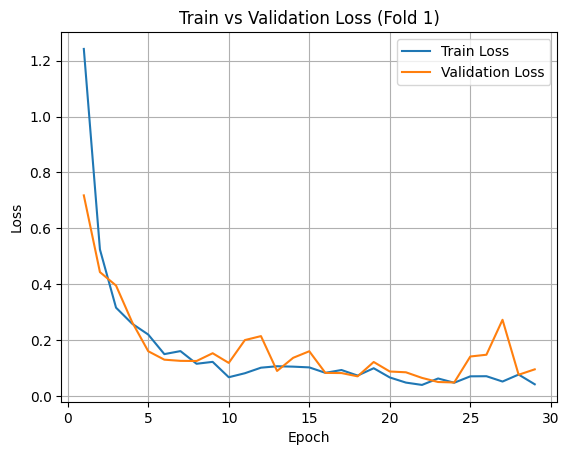

               precision    recall  f1-score   support

          low     1.0000    1.0000    1.0000        37
     moderate     1.0000    0.9655    0.9825        29
         high     0.8919    0.9706    0.9296        34
       mature     0.9767    0.9333    0.9545        45
poor dilation     1.0000    1.0000    1.0000        28

     accuracy                         0.9711       173
    macro avg     0.9737    0.9739    0.9733       173
 weighted avg     0.9727    0.9711    0.9714       173


===== Fold 2 =====
Train samples in fold 2: 689
Validation samples in fold 2: 172
Total used in this fold: 861
Total remaining consistent with train_val_df: 861
Train dataset length after transforms: 689
Val dataset length after transforms: 172
Model is on device: cuda:0
Epoch: [1/50] | Step: [1/11] | Loss: 1.593696
Epoch: [1/50] | Step: [6/11] | Loss: 1.327664
Epoch: [1/50] | Step: [11/11] | Loss: 0.994532
Epoch: [1/50] | Loss: 1.307005
Valid Loss: 1.291012 | Acc: 0.5988
Epoch: [2/50] | Step: [1

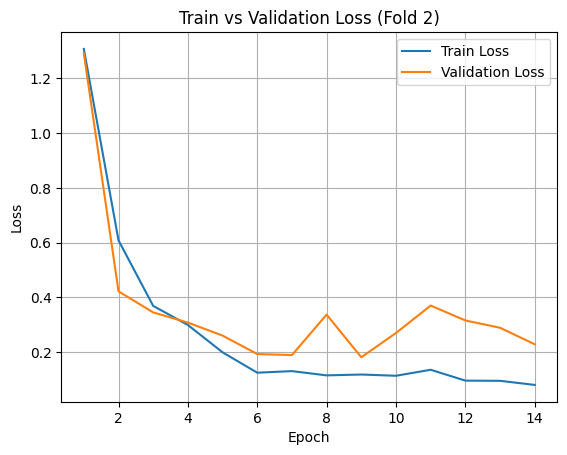

               precision    recall  f1-score   support

          low     0.9250    1.0000    0.9610        37
     moderate     1.0000    0.8929    0.9434        28
         high     0.9714    1.0000    0.9855        34
       mature     1.0000    1.0000    1.0000        45
poor dilation     1.0000    0.9643    0.9818        28

     accuracy                         0.9767       172
    macro avg     0.9793    0.9714    0.9744       172
 weighted avg     0.9782    0.9767    0.9766       172


===== Fold 3 =====
Train samples in fold 3: 689
Validation samples in fold 3: 172
Total used in this fold: 861
Total remaining consistent with train_val_df: 861
Train dataset length after transforms: 689
Val dataset length after transforms: 172
Model is on device: cuda:0
Epoch: [1/50] | Step: [1/11] | Loss: 1.625450
Epoch: [1/50] | Step: [6/11] | Loss: 1.167756
Epoch: [1/50] | Step: [11/11] | Loss: 0.860266
Epoch: [1/50] | Loss: 1.207384
Valid Loss: 1.221111 | Acc: 0.6279
Epoch: [2/50] | Step: [1

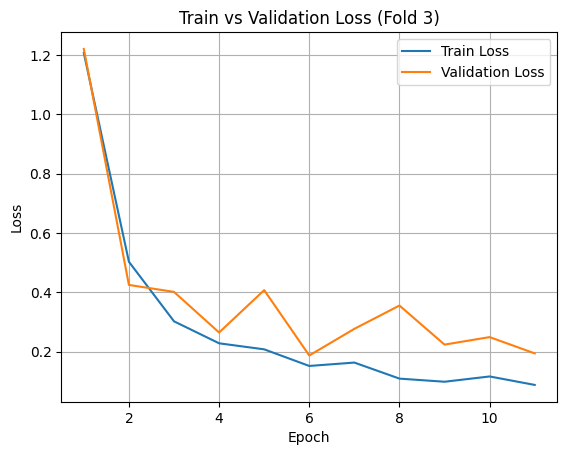

               precision    recall  f1-score   support

          low     1.0000    0.9730    0.9863        37
     moderate     0.9655    1.0000    0.9825        28
         high     1.0000    0.8485    0.9180        33
       mature     0.9000    1.0000    0.9474        45
poor dilation     0.9655    0.9655    0.9655        29

     accuracy                         0.9593       172
    macro avg     0.9662    0.9574    0.9599       172
 weighted avg     0.9624    0.9593    0.9589       172


===== Fold 4 =====
Train samples in fold 4: 689
Validation samples in fold 4: 172
Total used in this fold: 861
Total remaining consistent with train_val_df: 861
Train dataset length after transforms: 689
Val dataset length after transforms: 172
Model is on device: cuda:0
Epoch: [1/50] | Step: [1/11] | Loss: 1.632458
Epoch: [1/50] | Step: [6/11] | Loss: 1.200101
Epoch: [1/50] | Step: [11/11] | Loss: 0.974835
Epoch: [1/50] | Loss: 1.280302
Valid Loss: 0.680883 | Acc: 0.7209
Epoch: [2/50] | Step: [1

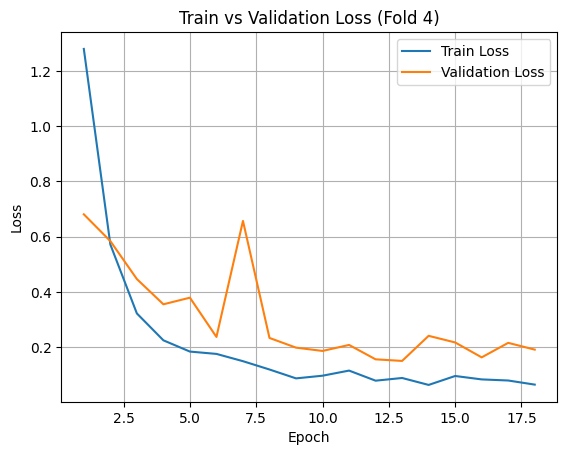

               precision    recall  f1-score   support

          low     0.9730    0.9730    0.9730        37
     moderate     0.9643    0.9643    0.9643        28
         high     0.9375    0.9091    0.9231        33
       mature     0.9362    0.9778    0.9565        45
poor dilation     1.0000    0.9655    0.9825        29

     accuracy                         0.9593       172
    macro avg     0.9622    0.9579    0.9599       172
 weighted avg     0.9597    0.9593    0.9593       172


===== Fold 5 =====
Train samples in fold 5: 689
Validation samples in fold 5: 172
Total used in this fold: 861
Total remaining consistent with train_val_df: 861
Train dataset length after transforms: 689
Val dataset length after transforms: 172
Model is on device: cuda:0
Epoch: [1/50] | Step: [1/11] | Loss: 1.648680
Epoch: [1/50] | Step: [6/11] | Loss: 1.286747
Epoch: [1/50] | Step: [11/11] | Loss: 0.925028
Epoch: [1/50] | Loss: 1.278990
Valid Loss: 0.704339 | Acc: 0.7326
Epoch: [2/50] | Step: [1

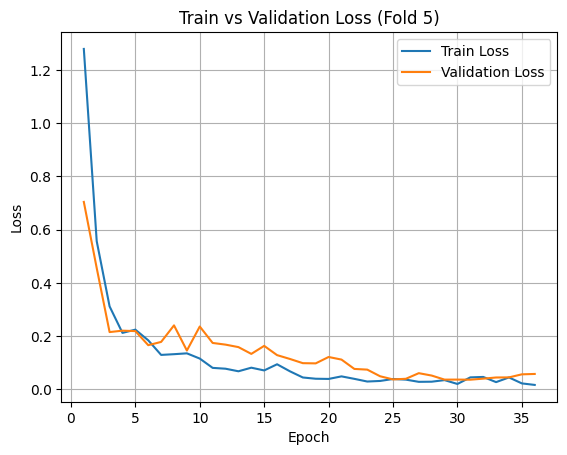

               precision    recall  f1-score   support

          low     1.0000    1.0000    1.0000        37
     moderate     1.0000    1.0000    1.0000        28
         high     0.9706    1.0000    0.9851        33
       mature     0.9778    0.9778    0.9778        45
poor dilation     1.0000    0.9655    0.9825        29

     accuracy                         0.9884       172
    macro avg     0.9897    0.9887    0.9891       172
 weighted avg     0.9885    0.9884    0.9884       172


===== Final Test Evaluation =====
               precision    recall  f1-score   support

          low     0.9706    1.0000    0.9851        33
     moderate     1.0000    0.9600    0.9796        25
         high     1.0000    1.0000    1.0000        29
       mature     1.0000    1.0000    1.0000        40
poor dilation     1.0000    1.0000    1.0000        25

     accuracy                         0.9934       152
    macro avg     0.9941    0.9920    0.9929       152
 weighted avg     0.9936 

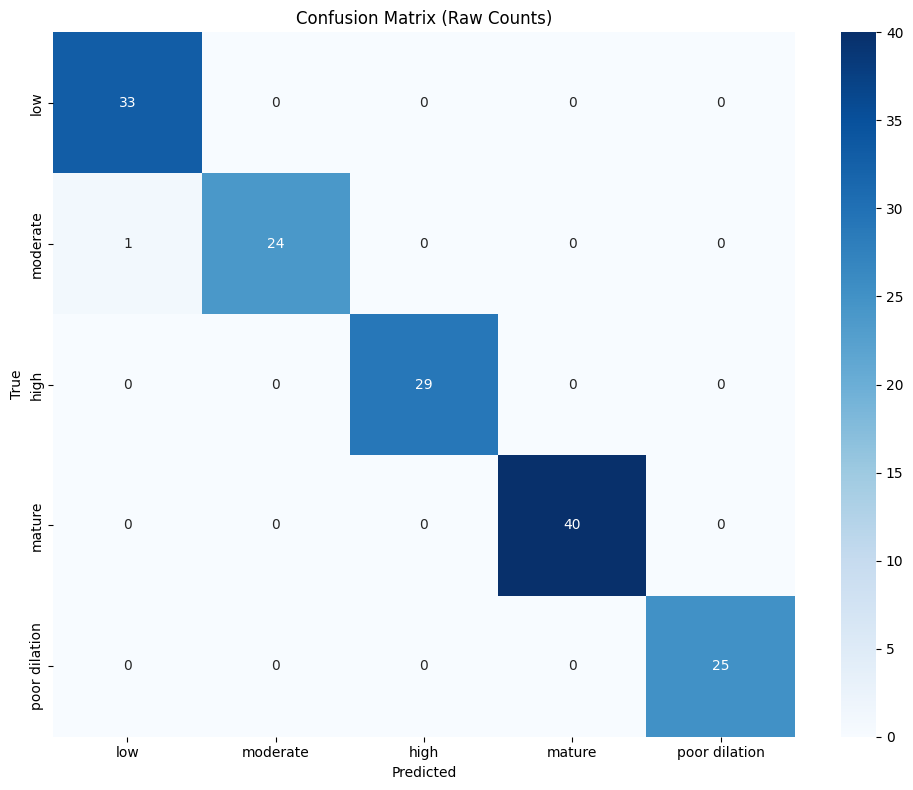

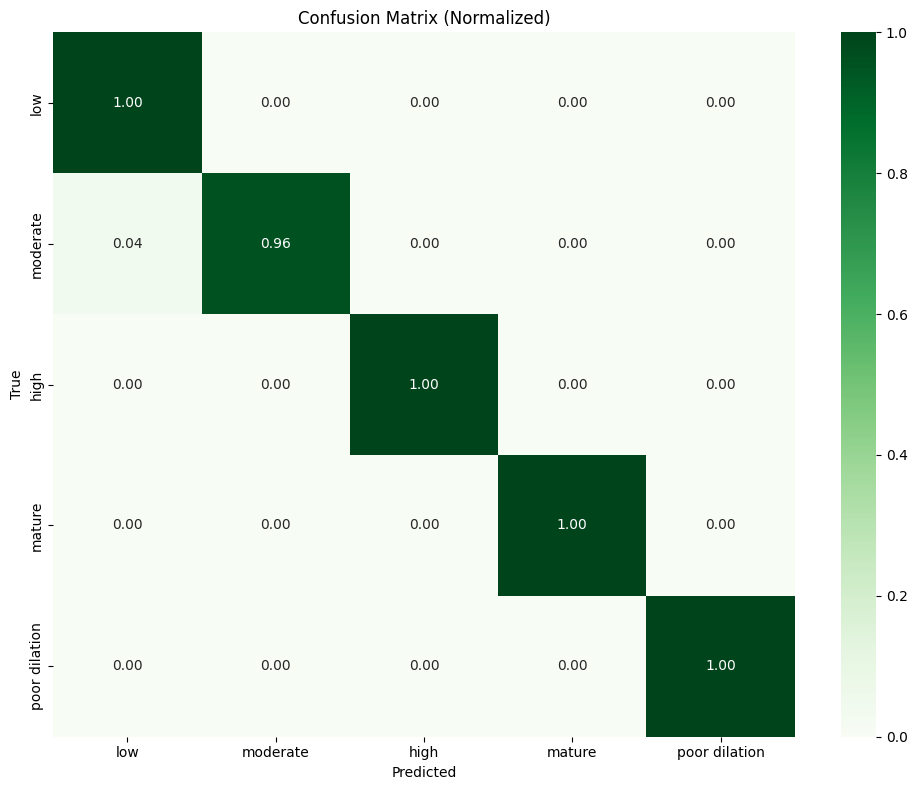

In [11]:
# ========== Train/Val/Test Split ==========
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


# Training settings
num_epochs = 50
patience = 5
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0
lr = 1e-3



DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# First: Split off 15% test set
train_val_df, test_df = train_test_split(
    df, test_size=0.15, stratify=df["label"], random_state=42
)

labels_train_val = train_val_df["label"].map(
    {"low":0, "moderate":1, "high":2, "mature":3, "poor dilation":4}
).values
labels_test = test_df["label"].map(
    {"low":0, "moderate":1, "high":2, "mature":3, "poor dilation":4}
).values

# Define classes
classes = ["low", "moderate", "high", "mature", "poor dilation"]

# Create test dataset and loader
test_dataset = CataractDataset(test_df, IMAGE_DIR, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# StratifiedKFold on remaining 85%
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)




fold_reports = []
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_df, labels_train_val)):
    print(f"\n===== Fold {fold+1} =====")

    # Reset early stopping for this fold
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Train/val splits
    train_df_fold = train_val_df.iloc[train_idx]
    val_df_fold = train_val_df.iloc[val_idx]

    print(f"Train samples in fold {fold+1}: {len(train_df_fold)}")
    print(f"Validation samples in fold {fold+1}: {len(val_df_fold)}")
    print(f"Total used in this fold: {len(train_df_fold) + len(val_df_fold)}")
    print(f"Total remaining consistent with train_val_df: {len(train_val_df)}")

    # Create datasets
    train_dataset = CataractDataset(train_df_fold, IMAGE_DIR, transform=transform)
    val_dataset   = CataractDataset(val_df_fold, IMAGE_DIR, transform=val_transform)

    # Report dataset lengths after transforms (should be identical)
    print(f"Train dataset length after transforms: {len(train_dataset)}")
    print(f"Val dataset length after transforms: {len(val_dataset)}")

    # # Create loaders
    # train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    # val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # print(f"Train samples in fold {fold+1}: {len(train_df_fold)}")
    # print(f"Validation samples in fold {fold+1}: {len(val_df_fold)}")
    # print(f"Total used in this fold: {len(train_df_fold) + len(val_df_fold)}")
    # print(f"Total remaining consistent with train_val_df: {len(train_val_df)}")


    # train_dataset = CataractDataset(train_val_df.iloc[train_idx], IMAGE_DIR, transform=transform)
    # val_dataset   = CataractDataset(train_val_df.iloc[val_idx], IMAGE_DIR, transform=val_transform)



    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # print(f"Train dataset length after transforms: {len(train_dataset)}")
    # print(f"Val dataset length after transforms: {len(val_dataset)}")


    # Compute class weights for this fold
    y_train_fold = [labels_train_val[i] for i in train_idx]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

#   Model
    model = efficientnet_b3(weights="DEFAULT", fine_tune=True)
    model = model.to(DEVICE)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)



    train_loss = []
    valid_loss = []

    print(f"Model is on device: {next(model.parameters()).device}")

    # Train loop
    num_steps = len(train_loader)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for j, (imgs, lbls) in enumerate(train_loader):
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            out = model(imgs)
            loss = loss_fn(out, lbls)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if j % 5 == 0:
                print(f'Epoch: [{epoch+1}/{num_epochs}] | Step: [{j+1}/{num_steps}] | Loss: {loss.item():.6f}')

        train_loss.append(running_loss / num_steps)
        print(f'Epoch: [{epoch+1}/{num_epochs}] | Loss: {train_loss[-1]:.6f}')

        # Validation
        model.eval()
        running_valid_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                out = model(imgs)
                loss_val = loss_fn(out, lbls)
                running_valid_loss += loss_val.item()
                predicted = torch.argmax(out, dim=1)
                correct += (predicted == lbls).sum().item()
                total += lbls.size(0)

        avg_val_loss = running_valid_loss / len(val_loader)
        valid_loss.append(avg_val_loss)
        acc_val = correct / total
        print(f'Valid Loss: {avg_val_loss:.6f} | Acc: {acc_val:.4f}')

        scheduler.step(avg_val_loss)

        # Early stopping
        if best_val_loss - avg_val_loss > min_delta:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    # Plot losses for this fold
    plt.figure()
    plt.plot(range(1, len(train_loss)+1), train_loss, label='Train Loss')
    plt.plot(range(1, len(valid_loss)+1), valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train vs Validation Loss (Fold {fold+1})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Validation report
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            out = model(imgs)
            preds = torch.argmax(out, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
    print(report)
    fold_reports.append(report)

# ===== Final Evaluation on Test Set =====
print("\n===== Final Test Evaluation =====")
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        out = model(imgs)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print(report)

# Confusion Matrices
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Raw Counts)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Normalized)')
plt.tight_layout()
plt.show()

